# WESAD
###  A Multimodal Dataset for Wearable Stress and Affect Detection

##### Matthew Johnson

--------

##### April 22, 2018

##### May 9, 2019
    ~~DONE: - add datetimes
    
##### May 11-12, 2019
    ~~TODO: - add more feats
            - hrv from bvp, peak detection [1]
            - lowpass eda (5hz) [1]
                - dynamic range?
                Details about the EDA-related features can be found in Choi et al.
                [3] and Healey et al. [6].
    - downsampling baseline data didn't help (removed now)
    - added new features from **cvxEDA
    - add features from readme files (gender, weight, height, smoker, etc.)
    - sub divide folders better
    
[1] Introducing WESAD... (do this)  

[3] J. Choi, B. Ahmed, and R. Gutierrez-Osuna. 2012. Development and evaluation
of an ambulatory stress monitor based on wearable sensors. IEEE Transactions
on Information Technology in Biomedicine 16, 2 (2012).  
    http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf
    
    
[6] J. Healey and **R. Picard.** 2005. Detecting stress during real-world driving tasks
using physiological sensors. IEEE Transactions on Intelligent Transportation
Systems 6, 2 (2005), 156–166.  


#### Useful Resources:
- https://github.com/jaganjag/stress_affect_detection
- https://github.com/arsen-movsesyan/springboard_WESAD
- https://www.birmingham.ac.uk/Documents/college-les/psych/saal/guide-electrodermal-activity.pdf
- http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf
- https://www.researchgate.net/publication/259560204_Is_There_More_to_Blood_Volume_Pulse_Than_Heart_Rate_Variability_Respiratory_Sinus_Arrhythmia_and_Cardiorespiratory_Synchrony

In [1]:
#! python3.6 data_wrangling3.py

## Dataset and Dataloading

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset


class WESADDataset(Dataset):
    def __init__(self):
        self.dataframe = pd.read_csv('may12_feats3.csv', index_col=0).drop('subject', axis=1)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
        
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)
    
from torch.utils.data.sampler import SubsetRandomSampler

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader       

In [3]:
dataset = WESADDataset()
x, y = dataset[0]
x.shape

torch.Size([41])

## Network Architecture

In [4]:
class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(41, 128),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(256, 3),
                        #nn.Dropout(0.5),
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)    

In [5]:
batch_size = 25

train_loader, validation_loader = get_training_and_validation_loaders(dataset, batch_size=batch_size)

#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 500
learning_rate = 1e-3
model = StressNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model Training

In [6]:
loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/500], Loss: 0.9442, Acc: 0.6
Epoch [2/500], Loss: 1.966, Acc: 0.56
Epoch [3/500], Loss: 1.081, Acc: 0.55
Epoch [4/500], Loss: 0.7001, Acc: 0.69
Epoch [5/500], Loss: 0.9017, Acc: 0.63
Epoch [6/500], Loss: 1.0, Acc: 0.63
Epoch [7/500], Loss: 0.7025, Acc: 0.71
Epoch [8/500], Loss: 0.8114, Acc: 0.68
Epoch [9/500], Loss: 0.6429, Acc: 0.73
Epoch [10/500], Loss: 0.7181, Acc: 0.72
Epoch [11/500], Loss: 0.7765, Acc: 0.77
Epoch [12/500], Loss: 0.7426, Acc: 0.73
Epoch [13/500], Loss: 0.7376, Acc: 0.71
Epoch [14/500], Loss: 0.6372, Acc: 0.75
Epoch [15/500], Loss: 0.5875, Acc: 0.78
Epoch [16/500], Loss: 0.9368, Acc: 0.73
Epoch [17/500], Loss: 0.5879, Acc: 0.77
Epoch [18/500], Loss: 0.5675, Acc: 0.78
Epoch [19/500], Loss: 0.5794, Acc: 0.77
Epoch [20/500], Loss: 0.6683, Acc: 0.74
Epoch [21/500], Loss: 0.6323, Acc: 0.78
Epoch [22/500], Loss: 0.6689, Acc: 0.73
Epoch [23/500], Loss: 0.571, Acc: 0.8
Epoch [24/500], Loss: 0.6587, Acc: 0.75
Epoch [25/500], Loss: 0.5814, Acc: 0.77
Epoch [26/500], L

Epoch [207/500], Loss: 0.527, Acc: 0.84
Epoch [208/500], Loss: 0.6557, Acc: 0.82
Epoch [209/500], Loss: 0.7044, Acc: 0.81
Epoch [210/500], Loss: 0.5732, Acc: 0.84
Epoch [211/500], Loss: 0.6863, Acc: 0.82
Epoch [212/500], Loss: 0.6859, Acc: 0.81
Epoch [213/500], Loss: 0.5549, Acc: 0.79
Epoch [214/500], Loss: 0.713, Acc: 0.84
Epoch [215/500], Loss: 0.7052, Acc: 0.82
Epoch [216/500], Loss: 0.4849, Acc: 0.84
Epoch [217/500], Loss: 0.5338, Acc: 0.84
Epoch [218/500], Loss: 0.5496, Acc: 0.86
Epoch [219/500], Loss: 0.5497, Acc: 0.84
Epoch [220/500], Loss: 0.6399, Acc: 0.85
Epoch [221/500], Loss: 0.781, Acc: 0.8
Epoch [222/500], Loss: 0.7034, Acc: 0.81
Epoch [223/500], Loss: 0.5387, Acc: 0.86
Epoch [224/500], Loss: 0.5609, Acc: 0.83
Epoch [225/500], Loss: 0.5548, Acc: 0.83
Epoch [226/500], Loss: 0.5669, Acc: 0.86
Epoch [227/500], Loss: 0.5237, Acc: 0.87
Epoch [228/500], Loss: 0.5683, Acc: 0.86
Epoch [229/500], Loss: 0.6169, Acc: 0.83
Epoch [230/500], Loss: 0.8691, Acc: 0.82
Epoch [231/500], Los

Epoch [409/500], Loss: 0.8278, Acc: 0.88
Epoch [410/500], Loss: 0.7719, Acc: 0.86
Epoch [411/500], Loss: 0.8537, Acc: 0.86
Epoch [412/500], Loss: 0.7682, Acc: 0.85
Epoch [413/500], Loss: 1.074, Acc: 0.85
Epoch [414/500], Loss: 0.8339, Acc: 0.85
Epoch [415/500], Loss: 0.9016, Acc: 0.85
Epoch [416/500], Loss: 1.017, Acc: 0.84
Epoch [417/500], Loss: 0.8513, Acc: 0.86
Epoch [418/500], Loss: 0.9905, Acc: 0.83
Epoch [419/500], Loss: 0.9726, Acc: 0.86
Epoch [420/500], Loss: 0.9032, Acc: 0.86
Epoch [421/500], Loss: 0.9702, Acc: 0.82
Epoch [422/500], Loss: 1.011, Acc: 0.84
Epoch [423/500], Loss: 0.8916, Acc: 0.84
Epoch [424/500], Loss: 1.054, Acc: 0.82
Epoch [425/500], Loss: 0.9231, Acc: 0.8
Epoch [426/500], Loss: 0.9858, Acc: 0.78
Epoch [427/500], Loss: 1.32, Acc: 0.86
Epoch [428/500], Loss: 0.787, Acc: 0.83
Epoch [429/500], Loss: 1.007, Acc: 0.86
Epoch [430/500], Loss: 0.9458, Acc: 0.86
Epoch [431/500], Loss: 0.9155, Acc: 0.85
Epoch [432/500], Loss: 0.8803, Acc: 0.86
Epoch [433/500], Loss: 0.

## Training Visualization

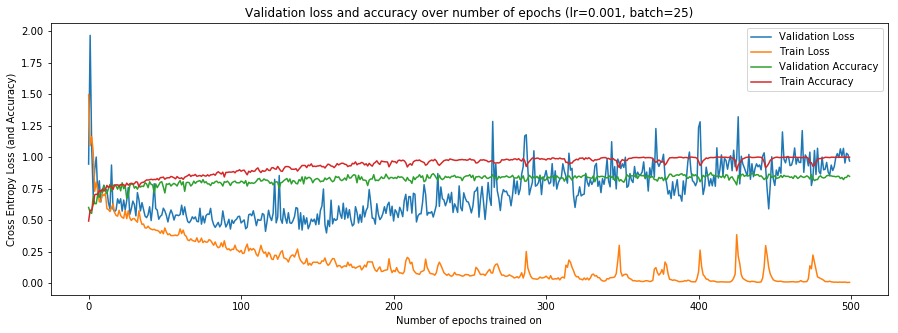

In [7]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title(f'Validation loss and accuracy over number of epochs (lr={learning_rate}, batch={batch_size})');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='upper right');

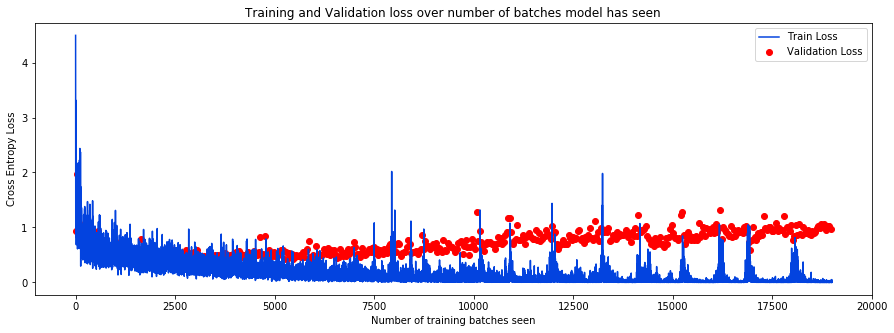

In [8]:
loader_len = len(train_loader)
x_vals= [loader_len*i for i in range(num_epochs)]
y_vals = loss_list

plt.subplots(figsize=(15,5))
plt.plot(train_losses2, color='xkcd:blue');
plt.scatter(x=x_vals, y=loss_list, color='red'); # validation losses
#plt.scatter(x=x_vals, y=acc_list, color='xkcd:green') # accs
plt.title('Training and Validation loss over number of batches model has seen');
plt.xlabel('Number of training batches seen');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');

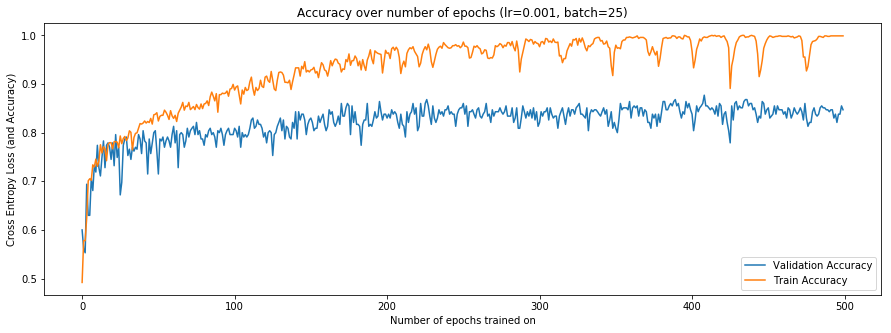

In [9]:
plt.subplots(figsize=(15,5))
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title(f'Accuracy over number of epochs (lr={learning_rate}, batch={batch_size})');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend([ 'Validation Accuracy', 'Train Accuracy'], loc='lower right');

## Model Evaluation

In [10]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 1.068, Acc: 0.85


In [11]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)
# rows actual, cols pred
cm

array([[ 27,  14,   0],
       [ 14, 109,   2],
       [  2,   4,  63]])

In [12]:
pd.DataFrame({'label': y_true})['label'].value_counts()

1    125
2     69
0     41
Name: label, dtype: int64

In [13]:
from sklearn.metrics import classification_report

target_names = ['Amusement', 'Baseline', 'Stress']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Amusement       0.63      0.66      0.64        41
    Baseline       0.86      0.87      0.87       125
      Stress       0.97      0.91      0.94        69

   micro avg       0.85      0.85      0.85       235
   macro avg       0.82      0.81      0.82       235
weighted avg       0.85      0.85      0.85       235



In [14]:
torch.save(model.state_dict(), 'm12_model.pt')